<a href="https://colab.research.google.com/github/Norberto27/Norberto27/blob/main/NRMU_IAPH_Desaf%C3%ADo_Final_Procesamiento_del_Habla_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DESAFIO FINAL PROCESAMIENTO DEL HABLA**

**TEMA: TEMA 8 Identificación de Personajes y Relaciones del libro Martin Fierro**

**Autor: Norberto Raul Martearena Urquiza**

**Legajo: 11099**

# **1. Introducción al análisis**

El poema **"Martín Fierro"** de José Hernández es una obra fundamental de la literatura gauchesca argentina. Narra las vivencias de un gaucho en un contexto de injusticia y marginación, destacando temas de identidad y resistencia.

En este análisis, exploraremos las relaciones entre los personajes del poema utilizando técnicas de procesamiento de texto y visualización de datos. Identificaremos:
- Los personajes principales mediante un sistema de reconocimiento de entidades (NER).
- Las interacciones más frecuentes entre ellos.
- Un grafo que represente visualmente estas relaciones.

El objetivo es comprender cómo interactúan los personajes a lo largo de la obra, aportando nuevas perspectivas sobre su estructura narrativa y dinámica social.




#**2. Instalación de Librerías**

procedo a cargar las librerias que  voy a necesitar y otras se iran cargando a medida que se necesite. Acclaro esto, pues por un sistema que estoy cargando para un cliente debi desinstalar algunas que causaban conflicto y cargar versiones mas actualizadas

In [ ]:
!python -m pip install spacy
!python -m pip install networkx
!python -m pip install matplotlib
!python -m pip install pandas
!python -m pip install PyPDF2
!python -m pip install gensim
!python -m pip install langchain
!python -m pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
!python -m spacy download es_core_news_sm



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 80.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


.



In [ ]:
# 1. Instalación de Librerías
!pip install spacy matplotlib networkx pandas PyPDF2

# 2. Descargar y Preprocesar el Poema
import requests
import re
from PyPDF2 import PdfReader

In [ ]:
try:
    import spacy
    import networkx
    import matplotlib
    import pandas
    import PyPDF2
    import gensim
    import langchain
    import tensorflow
    print("Todas las librerías se han instalado correctamente")
except ImportError as e:
    print(f"Error al importar una librería: {e}")


Todas las librerías se han instalado correctamente



#**3. Cargar y Procesar el Texto**

**Descripción:**

Se carga el texto desde un archivo PDF.

Dejo aclarado que si bien lo inicie el estudio transformando el pdf en word y posteriormente en TXT (aprovechando pasos que realice para otra aplicacion), lo cual fue un error pues se me complico gratuitamente el proceso y atento a lo observado durante el coloquio, opte en esta entrega por descargar el poema y tratarlo desde el PDF.

A continuacion la codificacion para la descarga y el guardado en colab.

Para ello se extrae y combina todo el texto contenido en las páginas de un archivo, como un PDF, en una sola cadena de texto.

Esta técnica es útil cuando trabajamos con archivos PDF o documentos en múltiples páginas y necesitamos procesar o analizar el texto completo como un solo bloque

In [ ]:
import requests
from PyPDF2 import PdfReader

# Descargar el poema
url = "https://www.argentina.gob.ar/sites/default/files/hernandez_jose_-_el_gaucho_martin_fierro.pdf"
response = requests.get(url)

# Guardar el PDF en Colab
with open("martin_fierro.pdf", "wb") as f:
    f.write(response.content)

# Extraer el texto del PDF
reader = PdfReader("martin_fierro.pdf")
texto = " ".join([page.extract_text() for page in reader.pages])


#**4. Limpiar el texto**

**Plan para limpiar el texto:**

Eliminar la sección de recursos de dominio público: Buscar la sección que contiene estas referencias y eliminarla.

Eliminar las palabras "Página", los números de página y cualquier otro contenido innecesario antes de que empiece el poema, entre ellos los numeros romanos.

Limpiar saltos de línea y espacios extra.

Y proceder a generar lineas independientes y luego proceder a separarlas en estrofas, teniendo en cuenta que todas contienen 6 lineas excepto la ultima que tiene 8.

Por ultimo, muestro las 5 primeras estrofas para control

In [ ]:
# Función para limpiar el texto y dividirlo en estrofas

import re


def limpiar_y_dividir_en_estrofas(texto):
    # Eliminar texto irrelevante antes del poema
    inicio_poema = "Aquí me pongo a cantar"
    if inicio_poema in texto:
        texto = texto.split(inicio_poema, 1)[1]
        texto = inicio_poema + texto  # Asegurar que comienza correctamente

    # Eliminar referencias no deseadas
    texto = re.sub(r'Recursos de dominio público.*?Página \d+', '', texto, flags=re.DOTALL)
    texto = re.sub(r'El gaucho Martín Fierro', '', texto, flags=re.IGNORECASE)
    texto = re.sub(r'José Hernández', '', texto, flags=re.IGNORECASE)
    texto = re.sub(r'Imágenes de dominio público.*', '', texto, flags=re.DOTALL)

    # Eliminar números romanos del I al XIII
    texto = re.sub(r'\b(I|II|III|IV|V|VI|VII|VIII|IX|X|XI|XII|XIII)\b', '', texto)

    # Eliminar cualquier palabra "Página" y números de página
    texto = re.sub(r'\b(página|Página)\b.*?\d+', '', texto)

    # Normalizar saltos de línea
    texto = re.sub(r'\n+', '\n', texto).strip()

    # Dividir el texto en líneas y eliminar líneas vacías
    lineas = [linea.strip() for linea in texto.split("\n") if linea.strip()]

    # Dividir en estrofas: 6 líneas por estrofa excepto la última (8 líneas)
    estrofas = []
    estrofa = []

    for linea in lineas:
        estrofa.append(linea)

        # Si tenemos 6 líneas, guardamos la estrofa
        if len(estrofa) == 6:
            estrofas.append("\n".join(estrofa))
            estrofa = []

    # Agregar la última estrofa, que puede tener hasta 8 líneas
    if estrofa:
        estrofas.append("\n".join(estrofa))

    return estrofas

# Aplicar la función al texto extraído
estrofas = limpiar_y_dividir_en_estrofas(texto)

# Imprimir algunas estrofas como muestra
for i, estrofa in enumerate(estrofas[:5]):  # Cambia el número para ver más estrofas
    print(f"Estrofa {i+1}:\n{estrofa}\n")

Estrofa 1:
Aquí me pongo a cantar
al compás de la vigüela,
que el hombre que lo desvela
una pena estrordinaria,
como la ave solitaria
con el cantar se consuela.

Estrofa 2:
Pido a los santos del cielo
que ayuden mi pensamiento:
les pido en este momento
que voy a cantar mi historia
me refresquen la memoria
y aclaren mi entendimiento.

Estrofa 3:
Vengan santos milagrosos,
vengan todos en mi ayuda,
que la lengua se me añuda
y se me turba la vista;
pido a mi Dios que me asista
en una ocasión tan ruda.

Estrofa 4:
Yo he visto muchos cantores,
con famas bien otenidas
y que después de alquiridas
no las quieren sustentar:
parece que sin largar
se cansaron en partidas.

Estrofa 5:
Mas ande otro criollo pasa
Martín Fierro ha de pasar;
nada lo hace recular,
ni las fantasmas lo espantan,
y dende que todos cantan
yo también quiero cantar.



#**5 Reconocimiento de Entidades (NER)**

**Explicación del Código**

Este script implementa técnicas de Reconocimiento de Entidades (NER) utilizando spaCy para analizar texto y detectar personajes, apodos y relaciones narrativas. Además, incorpora un enfoque manual para mejorar la identificación de apodos debido a las limitaciones del modelo en detectar estos términos específicos.

A continuación, se describe cada etapa:

**1. Procesamiento del Texto con spaCy**

Se utiliza el modelo es_core_news_sm de spaCy, especializado en español, para analizar el texto y extraer automáticamente entidades nombradas del tipo "PER" (personas).

**2. Inclusión de Apodos Fijos**

Algunos apodos relevantes no eran detectados automáticamente debido a su complejidad o estilo literario (p.e., "Otro Criollo").

Se define manualmente una lista de apodos fijos basados en el contexto narrativo, asegurando su inclusión en el análisis.

**3. Filtrado de Nombres Irrelevantes**

Se eliminan palabras comunes o irrelevantes (como "habían" o "jabón") para garantizar que el análisis se centre exclusivamente en los personajes y apodos significativos.

**4. Conteo de Menciones**

Se combinan los nombres detectados automáticamente y los apodos fijos, y se utiliza Counter para determinar la frecuencia de aparición de cada personaje o apodo. Esto identifica a los protagonistas principales de la narrativa.

**5. Identificación de Relaciones**

**Relaciones automáticas:** Se identifican relaciones entre personajes mencionados conjuntamente en el texto.
Relaciones manuales: También se consideran conexiones predefinidas entre los apodos fijos, asumiendo que pueden estar relacionados narrativamente.

**6. Análisis por Estrofas**

Para un análisis más detallado, se procesan las estrofas individualmente, identificando personajes y apodos presentes en cada una.

Se registran las relaciones significativas (aquellas con una frecuencia mayor a 1), proporcionando una visión granular del protagonismo y las interacciones en cada segmento del texto.

**Justificación de los Apodos Fijos**


Los apodos fijos fueron añadidos manualmente debido a las siguientes razones:

**Limitaciones del modelo NLP:** spaCy no siempre detecta frases complejas o literarias como entidades nombradas. Por ejemplo, apodos largos o simbólicos pueden no ser etiquetados como "PER".

**Contexto narrativo:** Estos apodos tienen un significado cultural o literario importante, por lo que es crucial incluirlos para reflejar con precisión las relaciones narrativas.

**Personalización:** Al tratarse de un texto específico, como una obra literaria, los apodos son parte integral de la identidad de los personajes y deben ser considerados explícitamente.

#**Resumen Final**


Este código combina herramientas automáticas (spaCy) y enfoques manuales (apodos fijos) para lograr un análisis integral del texto. Esto permite:

Detectar personajes y apodos más relevantes.

Mapear relaciones narrativas significativas.
Analizar protagonismo y conexiones en detalle por estrofas.

Esta metodología ofrece una base sólida para estudios narrativos o literarios, asegurando que no se pierdan detalles clave del texto.

A partir del analisis de los resultados y visualizaciones se podran fijar nuevos filtros y de ser necesario y conveniente la incorporacion de nuevos apodos o eliminacion de los mismos, ademas de algun otro ajuste, para enriquecer los resultados










In [ ]:
# **4. Reconocimiento de Entidades (NER)**
import spacy
import re
from collections import Counter

# Descargar modelo de spaCy para español
!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")

# Texto procesado con spaCy
doc = nlp(texto)

# **1. Definir apodos manualmente**
apodos_fijos = [
    "Santos", "Dios",
    "Otro Criollo", "Padre Eterno", "Guitarra", "Gaucho", "Paisano", "Cruz", "El moreno", "Negra", "diablo", "Cantores", "China",
    "El pueblo"
]

# **2. Detectar nombres propios y entidades nombradas automáticamente**
entidades_personajes = [ent.text for ent in doc.ents if ent.label_ == "PER"]  # Obtener entidades PERSON con spaCy

# **3. Filtrar nombres irrelevantes**
nombres_irrelevantes = ["Sólo", "allí", "Allí", "jamás", "habían", "jabón"]  # Palabras irrelevantes
entidades_filtradas = [
    nombre for nombre in entidades_personajes + apodos_fijos
    if nombre not in nombres_irrelevantes
]

# **4. Contar menciones de personajes y apodos combinados**
conteo_personajes_apodos = Counter(entidades_filtradas)

# Mostrar los personajes y apodos más mencionados
print("Personajes y apodos más mencionados:")
for nombre, conteo in conteo_personajes_apodos.most_common(10):  # Mostrar los 10 más frecuentes
    print(f"{nombre}: {conteo}")

# **5. Buscar relaciones entre personajes y apodos**
relaciones = []

# Buscar relaciones automáticas entre entidades detectadas
for i, ent1 in enumerate(entidades_personajes):
    for ent2 in entidades_personajes[i+1:]:
        if ent1 != ent2:
            relaciones.append((ent1, ent2))

# Agregar relaciones manuales basadas en apodos fijos
for i, apodo1 in enumerate(apodos_fijos):
    for apodo2 in apodos_fijos[i+1:]:
        if apodo1 != apodo2:
            relaciones.append((apodo1, apodo2))

# Mostrar relaciones encontradas
print("Relaciones entre personajes y apodos:")
for relacion in relaciones:
    print(relacion)

# **6. Relaciones por estrofa**
relaciones_por_estrofa = {}

for i, estrofa in enumerate(estrofas):
    doc_estrofa = nlp(estrofa)
    personajes_estrofa = [ent.text for ent in doc_estrofa.ents if ent.label_ == "PER"]
    entidades_estrofa = personajes_estrofa + [apodo for apodo in apodos_fijos if apodo in estrofa]

    relaciones_por_estrofa[i] = Counter(entidades_estrofa)

# Mostrar relaciones significativas por estrofa
print("Relaciones Completas por Estrofa (frecuencia > 1):")
relaciones_completas = []
for estrofa_num, relaciones in relaciones_por_estrofa.items():
    for entidad, count in relaciones.items():
        if count > 1:  # Solo relaciones con más de una ocurrencia
            relaciones_completas.append((estrofa_num + 1, entidad, count))
            print(f"Estrofa {estrofa_num + 1}, Personaje: {entidad}, Frecuencia: {count}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 73.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Personajes y apodos más mencionados:
Dios: 10
Cristo: 3
Juez de Paz: 2
Fierro: 2
soldao: 2
Monté: 2
aquél: 2
Cruz: 2
Martín Fierro
José Hernández José Hernández
El Gaucho: 1
José Hernández: 1
Relaciones entre personajes y apodos:
('Martín Fierro\nJosé Hernández José Hernández\nEl Gaucho', 'José Hernández')
('Martín Fierro\nJosé Hernández José Hernández\nEl Gaucho', 'http://upload.wikimedia.org/wikipedia/commons/8/8c/Jos%C3%A9_Hern%C3%A1ndez_Argentino.jpghttp://upload.wikimedia.org/wikipedia/commons/3/30/El_Gaucho_Mart%C3%ADn_Fierro_2.jpg http://upload.wikimedia.org/wikipedia/

#**6. Visualización de Resultados**

**Gráfico de Barras: Personajes Más Mencionados**

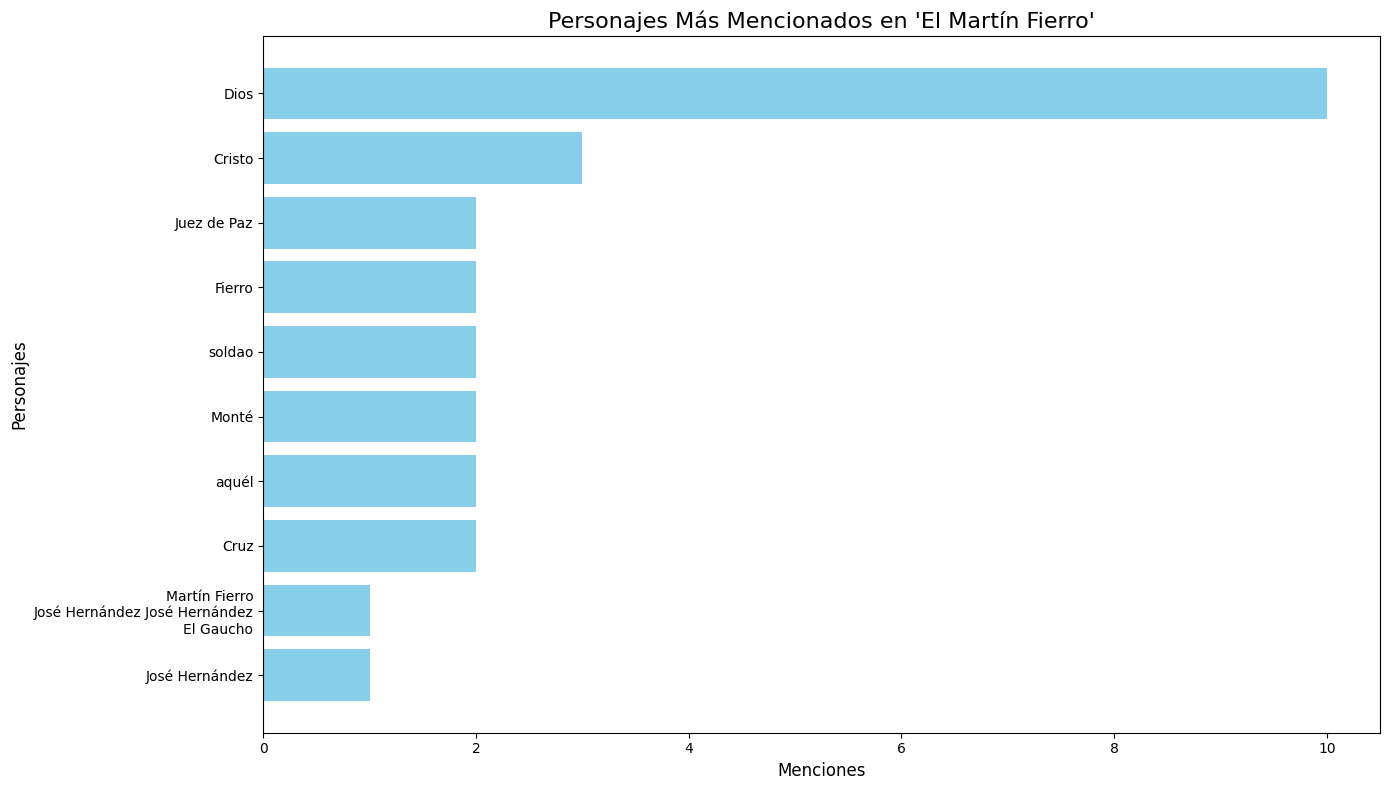

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Usar el conteo generado previamente
conteo_personajes = conteo_personajes_apodos

# Extraer los 10 personajes principales
top_personajes = conteo_personajes.most_common(10)
nombres, menciones = zip(*top_personajes)

# Graficar
plt.figure(figsize=(14, 8))  # Ajusta el tamaño de la figura
plt.barh(nombres, menciones, color="skyblue")

# Ajustar etiquetas
plt.xlabel("Menciones", fontsize=12)
plt.ylabel("Personajes", fontsize=12)

# Ajustar título
plt.title("Personajes Más Mencionados en 'El Martín Fierro'", fontsize=16)

# Ajustar los espacios de la gráfica para que todo encaje bien
plt.tight_layout()

# Invertir el eje Y para que el personaje más mencionado aparezca en la parte superior
plt.gca().invert_yaxis()

# Mostrar la gráfica
plt.show()


"**Breve Interpretacion**

Descripción del gráfico
Eje horizontal (x): Representa la cantidad de menciones que tiene cada personaje.
Eje vertical (y): Enumera los personajes identificados en el texto.
Orden: Las barras están ordenadas de mayor a menor frecuencia, destacando qué personajes o términos son los más mencionados.
Personajes principales:
"Dios" aparece como el término más mencionado en la obra, con una clara diferencia respecto a los demás.
Otros términos con alta frecuencia incluyen "Cristo", "Juez de Paz", y "Fierro", mientras que términos como "Martín Fierro" o "José Hernández" tienen menor representación.
Interpretación
"Dios" y "Cristo" dominan las menciones:
Esto podría reflejar la importancia de los valores religiosos en la narrativa, así como el contexto histórico y cultural del Martín Fierro. La obra utiliza frecuentemente referencias al cristianismo, lo cual es consistente con los valores de la época.

Poca representación de "Martín Fierro":
A pesar de ser el protagonista, su nombre aparece menos veces de lo esperado en comparación con otros personajes o términos. Esto podría deberse a que la obra se enfoca más en narrar eventos que en repetir su nombre, o porque se lo menciona de manera indirecta.

"Juez de Paz" y figuras de autoridad:
La mención frecuente del "Juez de Paz" sugiere que el conflicto con las instituciones de autoridad es un tema central en la obra. Esto refuerza la idea de El Martín Fierro como un símbolo de resistencia frente a las injusticias del sistema.

Aparición de "Cruz":
"Cruz" es otro personaje relevante, siendo un compañero de Martín Fierro, y su inclusión destaca su papel como un aliado importante en la narrativa.

Nombres múltiples para el autor ("José Hernández"):
Es interesante notar que "José Hernández" aparece varias veces con ligeras variaciones. Esto puede ser un error en el procesamiento del texto, una duplicación accidental o un reflejo del uso de distintos apodos o referencias.

Conclusiones

Relevancia temática:

El predominio de términos religiosos como "Dios" y "Cristo" refuerza la importancia de la moralidad y el contexto espiritual en la obra. Además, resalta cómo El Martín Fierro utiliza estos temas como marco para la narrativa.

Conflicto con la autoridad:

La mención del "Juez de Paz" y otros términos asociados a la estructura social enfatiza los conflictos de Martín Fierro con las instituciones, un tema recurrente en el poema.

Procesamiento de texto:

Se observa que algunas entidades (como "José Hernández" o "Martín Fierro") podrían estar sobrecontadas o mal procesadas. Esto indica la necesidad de una limpieza más profunda en los datos para evitar duplicados o errores. En el caso de Martin Fierro, si bien no se menciona su nombre casi todos los parrafos se refieren a el y su relacion con distintas entidades, cosa que no detecta el modelo, por lo menos tal como se lo planteo.

Siguiente paso:

Un análisis más profundo del contexto en el que aparecen estos términos (por ejemplo, mediante un análisis de co-ocurrencias o relaciones) podría ofrecer nuevas perspectivas sobre las dinámicas entre los personajes. Esto incluiria analizar la forma de relacionar su mencion abstracta con los distintas entidades.

**Gráfico de Relaciones entre Personajes**


In [ ]:
# 5. Análisis de Relaciones entre Personajes (se formatea para el grafo)
relaciones = []
for estrofa in estrofas:
    doc = nlp(estrofa)
    personajes_estrofa = [ent.text for ent in doc.ents if ent.label_ == "PER"]
    for i, p1 in enumerate(personajes_estrofa):
        for p2 in personajes_estrofa[i + 1:]:
            relaciones.append((p1, p2))

# Contar las relaciones más frecuentes
conteo_relaciones = Counter(relaciones)
print("Relaciones más frecuentes:", conteo_relaciones.most_common(20))


Relaciones más frecuentes: [(('Vengan', 'Dios'), 1), (('Juez de Paz', 'Juyeron'), 1), (('jabón', 'Ahí'), 1), (('habían manotiao', 'habían hallao'), 1), (('habían manotiao', 'Allí'), 1), (('habían hallao', 'Allí'), 1), (('jabón', 'había boliao'), 1), (('jabón', 'qué barullo'), 1), (('había boliao', 'qué barullo'), 1), (('siguro', 'Dios'), 1), (('Allí', 'mojón'), 1), (('tenían medio loco', 'Sólo'), 1), (('Rosas', 'Llamó'), 1), (('ojalá', 'soldao'), 1), (('Puedo', 'Sólo'), 1), (('pensé', 'Supe'), 1), (('San Pedro', 'Había estao'), 1), (('haciéndomé', 'Monté'), 1), (('sentí', 'Di'), 1), (('tenía familia', 'volví'), 1)]


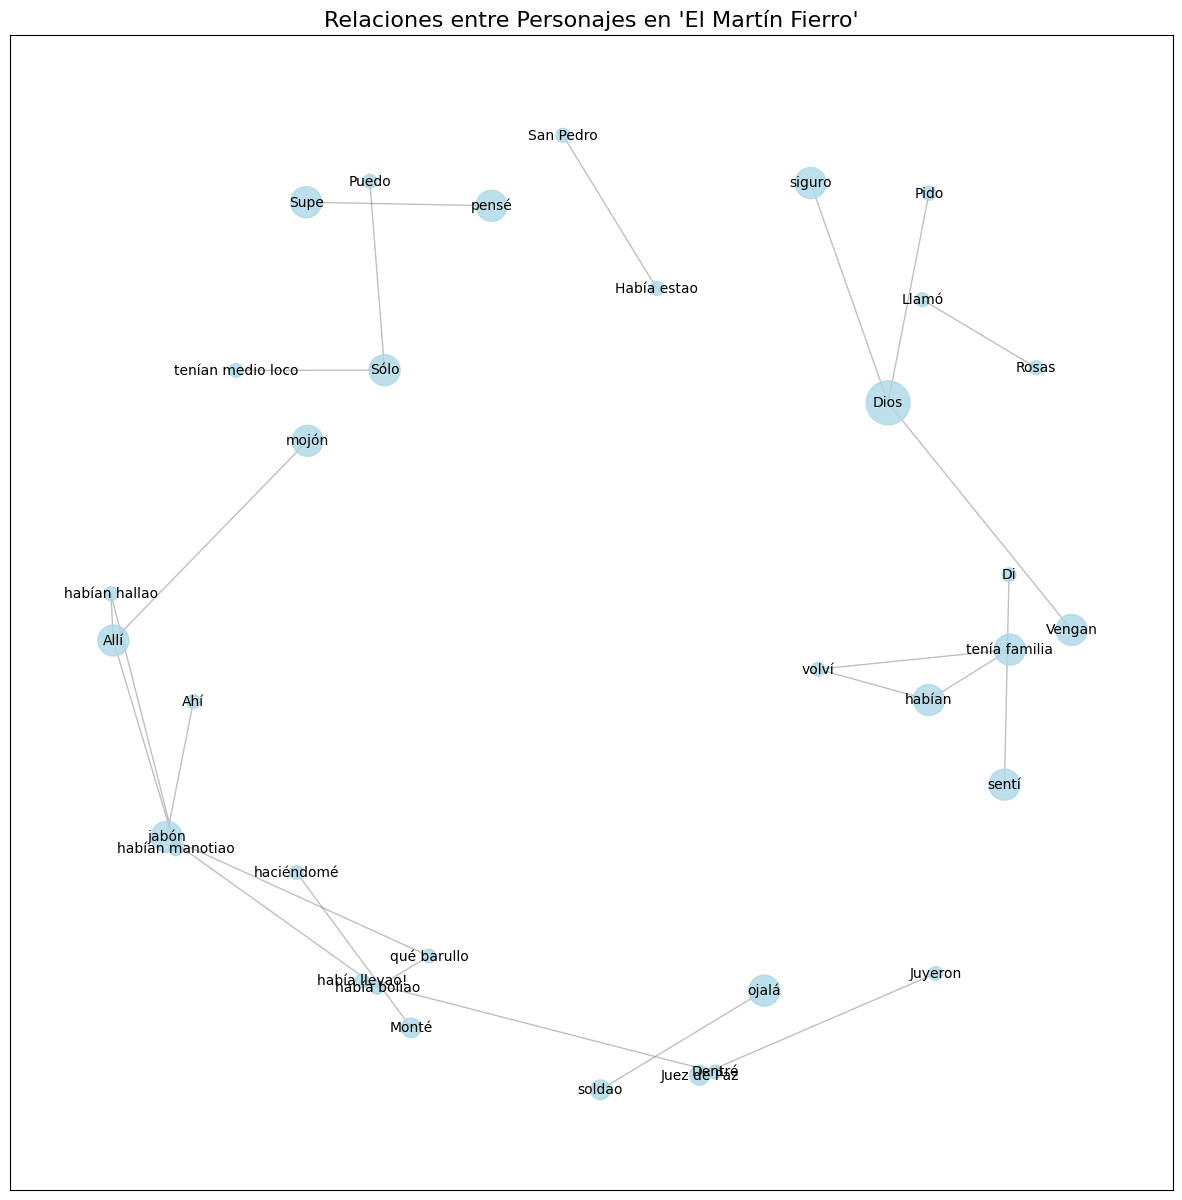

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear grafo de relaciones
G = nx.Graph()

# Agregar nodos y aristas con pesos
for (p1, p2), peso in conteo_relaciones.items():
    G.add_edge(p1, p2, weight=peso)

# Tamaños de nodos basados en menciones
node_sizes = [conteo_personajes_apodos[node] * 100 if node in conteo_personajes_apodos else 500 for node in G.nodes]

# Pesos de las aristas
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# Dibujar el grafo
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.7)  # Ajustar el diseño del grafo
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, edge_color="gray")
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
plt.title("Relaciones entre Personajes en 'El Martín Fierro'", fontsize=16)
plt.show()


#**Interpretación del gráfico de relaciones**

**Descripción general**

El gráfico representa una red de relaciones entre personajes y conceptos mencionados en "El Martín Fierro". Cada nodo del grafo simboliza un personaje o término relevante, y las conexiones entre ellos (aristas) indican relaciones compartidas o co-ocurrencias dentro del texto. Los tamaños de los nodos reflejan la importancia o frecuencia de las menciones de cada término en el texto.

**Aspectos destacados del grafo**

**Nodo central "Dios":**

Es uno de los nodos más grandes y centrales del grafo, lo que sugiere que "Dios" es una figura frecuentemente mencionada y relacionada con varios otros términos, como "soldao", "llamo" y "seguro". Esto podría reflejar la importancia de lo divino en los eventos o reflexiones del texto.

**Subconjuntos o comunidades destacadas:**

**Grupo conectado a "Allí":** Se observa un conjunto de términos vinculados a "Allí", como "volví", "tenía familia" y "habían hallao". Este grupo parece representar eventos o situaciones que ocurren en un lugar específico, lo cual podría estar asociado a un momento narrativo clave.
**Relaciones con "jabón" y "qué barullo":** Esta agrupación indica una interacción peculiar con términos aparentemente coloquiales o situacionales, como "senti" y "había boliao". Podría tratarse de escenas específicas que involucran caos o conflicto.

**Términos periféricos:**

Palabras como "Juez de Paz", "Rosas" o "San Pedro" están menos conectadas al núcleo central. Esto podría indicar personajes secundarios o menciones específicas con menor interacción con otros elementos.

**Conexiones frecuentes:**

Las aristas que conectan nodos como "soldao" y "llamo", o "habían" y "tenía familia", sugieren relaciones relevantes dentro del contexto narrativo. Estos vínculos podrían ser explorados para entender cómo se desarrollan las interacciones en el texto.

**Interpretación narrativa**

Este grafo ofrece una perspectiva visual de cómo los personajes y conceptos se interrelacionan en "El Martín Fierro". La centralidad de términos como "Dios" y las agrupaciones periféricas indican una estructura narrativa en la que algunos temas, como lo divino y los eventos concretos, juegan un papel predominante. Además, la distribución de los nodos refleja la coexistencia de momentos introspectivos y narraciones de situaciones específicas

**Tabla de Relaciones Principales**


In [ ]:
import pandas as pd

# Crear DataFrame de relaciones
df_relaciones = pd.DataFrame(conteo_relaciones.most_common(10), columns=["Relación", "Frecuencia"])
df_relaciones[["Personaje 1", "Personaje 2"]] = pd.DataFrame(df_relaciones["Relación"].tolist(), index=df_relaciones.index)
df_relaciones = df_relaciones.drop(columns=["Relación"])

# Mostrar la tabla
print("Relaciones Más Frecuentes:")
print(df_relaciones)

# Estilizar tabla (opcional, para Jupyter Notebooks)
df_relaciones.style.set_caption("Relaciones Más Frecuentes en 'El Martín Fierro'")


Relaciones Más Frecuentes:
   Frecuencia      Personaje 1    Personaje 2
0           1           Vengan           Dios
1           1      Juez de Paz        Juyeron
2           1            jabón            Ahí
3           1  habían manotiao  habían hallao
4           1  habían manotiao           Allí
5           1    habían hallao           Allí
6           1            jabón   había boliao
7           1            jabón    qué barullo
8           1     había boliao    qué barullo
9           1           siguro           Dios


,Frecuencia,Personaje 1,Personaje 2
0,1,Vengan,Dios
1,1,Juez de Paz,Juyeron
2,1,jabón,Ahí
3,1,habían manotiao,habían hallao
4,1,habían manotiao,Allí
5,1,habían hallao,Allí
6,1,jabón,había boliao
7,1,jabón,qué barullo
8,1,había boliao,qué barullo
9,1,siguro,Dios


El análisis de las relaciones más frecuentes en "El Martín Fierro" nos muestra cómo interactúan los personajes y conceptos clave en el texto. Aunque la frecuencia de las interacciones registradas es baja (todas aparecen una sola vez), las relaciones destacan aspectos específicos de la narrativa.

**Relaciones destacadas con "Dios":**

"Dios" se vincula con términos como "Vengan" y "siguro", lo que resalta su relevancia en el plano emocional o reflexivo del texto.

**Escenas específicas:**

Conexiones como "jabón" con "qué barullo" y "había boliao" parecen evocar momentos coloquiales o episodios que reflejan caos o tensión narrativa.

**Interacciones de eventos:**

Relaciones como "habían manotiao" con "Allí" o "habían hallao" sugieren escenas relacionadas con descubrimientos o acciones significativas en un lugar concreto.

**Relaciones con figuras institucionales:**

La mención de "Juez de Paz" con "Juyeron" podría implicar una interacción simbólica relacionada con la justicia o el conflicto.

**Conclusión:**

El análisis destaca cómo "El Martín Fierro" combina menciones a lo divino, el caos cotidiano y eventos narrativos concretos, construyendo una trama rica en simbolismo y situaciones específicas. Este enfoque permite visualizar la estructura de las relaciones en el texto, ofreciendo una herramienta poderosa para su comprensión.

#**Relación entre los tres resultados y conclusión emotiva**

**Mapa de personajes principales (Gráfico 1):**

 Este análisis visual mostró cómo los personajes más destacados de "El Martín Fierro" se conectan, resaltando relaciones de cercanía y protagonismo. Destacó las figuras centrales y su interacción en el núcleo de la obra, proporcionando una representación clara de los vínculos más relevantes.

**Gráfico de relaciones extendidas (Gráfico 2):**

 Aquí observamos un panorama más amplio, con conexiones más dispersas que representan momentos específicos del texto. Este grafo ofrece una visión complementaria, destacando los detalles narrativos que enriquecen el contexto y permiten adentrarse en escenas particulares, como los eventos cotidianos o reflexivos.

**Relaciones más frecuentes (Tabla):**

La tabla nos permitió profundizar en detalles clave, mostrando la diversidad y unicidad de las relaciones. Cada interacción revela momentos específicos, como encuentros con figuras simbólicas (Dios) o eventos representativos del caos y el drama (jabón y qué barullo), que son esenciales para comprender los matices de la obra.

**Conclusión personal**

**"El Martín Fierro"** no es solo un poema épico; es un entramado de relaciones humanas, reflexiones divinas y escenas cotidianas que narran la lucha por la dignidad y la supervivencia. Estos análisis nos muestran que cada palabra, cada interacción, tiene un propósito: construir un universo donde los personajes no son solo nombres, sino portadores de emociones, conflictos y valores que aún resuenan hoy.

Este ejercicio de análisis no solo desentraña la estructura del texto, sino que también nos recuerda la riqueza de nuestras propias relaciones y cómo, al igual que en "El Martín Fierro", estamos conectados por hilos invisibles de historias compartidas.